In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import product
from typing import Dict, Tuple
from IPython.display import display
from matplotlib import pyplot as plt

# Package dependencies:
# https://github.com/anabugaenko/liquidity
# https://github.com/anabugaenko/market_impact

from liquidity.features import compute_aggregate_features

from market_impact.function_form import scaling_form, scaling_law
from market_impact.response_functions import aggregate_impact
from market_impact.fit import fit_scaling_form, fit_scaling_law 
from market_impact.fss import find_shape_parameters, find_scale_factors, transform
from market_impact.util.data_utils import normalize_imbalances, bin_data_into_quantiles, smooth_outliers, plot_scaling_form, plot_scaling_law

In [2]:

# Automatically reload changes in package dependencies
%load_ext autoreload
%autoreload 2
warnings.filterwarnings('ignore')

# Nonlinear aggregate price impact analysis 

See:

Lillo, F., Farmer, J.D. and Mantegna, R.N., 2003. Master curve for </br>
price-impact function. Nature, 421(6919), pp.129-130.

Patzelt, F. and Bouchaud, J.P., 2018. Universal scaling and nonlinearity of </br>
aggregate price impact in financial markets. Physical Review E, 97(1), p.012304.</br>

## Finitie-size scaling analysis
Finite-size scaling analysis a powerful tool that enables extraction of exponent of critical phenomena. Given data describing some dimensionless quantity, we estimate universal information from observables at finite-size system. The derivation of such scaling laws is supported by the renormalization-group argument. This notebook introduces a FSS based on the method of Leas-squares.

In [3]:
# Constants 
BINNING_FREQUENCIES = list(range(10, 151))
OBSERVATION_WINDOWS = [10, 20, 50, 100, 150]

In [4]:
# Load orderbook raw sample data
stocks = ['TSLA', 'AMZN', 'NFLX', 'MSFT', 'EBAY', 'AAPL', 'GOOG']

current_dir = os.path.abspath('.')
root_dir = os.path.join(current_dir, '..', '..')
data_dir = os.path.join(root_dir, 'data', 'market_orders')

stock_data = {}

# Loop through each stock
for stock in stocks:

    filename = f"{stock}-2017-NEW.csv"

    stock_file_path = os.path.join(data_dir, filename)

    # Read the CSV and store in the dictionary
    stock_data[stock] = pd.read_csv(stock_file_path)

# Access the dataframe using stock's ticker as key
tsla_raw_df = stock_data['TSLA']
amzn_raw_df = stock_data['AMZN']
nflx_raw_df = stock_data['NFLX']
msft_raw_df = stock_data['MSFT']
ebay_raw_df = stock_data['EBAY']
aapl_raw_df = stock_data['AAPL']
goog_raw_df = stock_data['GOOG']

In [5]:
aapl_raw_df.head()

,Unnamed: 0,event_timestamp,sign,side,lob_action,order_executed,execution_price,size,ask,bid,...,average_vol_at_best,midprice_change,R1,spread,date,daily_R1,daily_vol,daily_num,norm_size,signed_volume
0,0,2017-01-03 10:30:00.544161131,1,ASK,REMOVE,True,115.70,100,115.70,115.69,...,1045.040418,0.00,0.00,0.01,2017-01-03,0.004271,1398089,6170,0.095690,100
1,1,2017-01-03 10:30:02.758712611,-1,BID,REMOVE,True,115.69,153,115.70,115.69,...,762.184840,-0.01,0.01,0.01,2017-01-03,0.004271,1398089,6170,0.200739,-153
2,2,2017-01-03 10:30:02.852790059,1,ASK,REMOVE,True,115.69,200,115.69,115.68,...,1045.040418,0.01,0.01,0.01,2017-01-03,0.004271,1398089,6170,0.191380,200
3,3,2017-01-03 10:30:04.539218241,1,ASK,REMOVE,True,115.70,100,115.70,115.69,...,1045.040418,0.00,0.00,0.01,2017-01-03,0.004271,1398089,6170,0.095690,100
4,4,2017-01-03 10:30:07.865732286,1,ASK,UPDATE,True,115.70,10,115.70,115.69,...,1045.040418,0.00,0.00,0.01,2017-01-03,0.004271,1398089,6170,0.009569,10


### Aggregate features 
We first coarse-grain the data into different binning frequencies $T$ that represent different system sizes (in event time) by marginalize over microscopic degrees of freedom in the system to yield an effective coarse-grained description at long distances.

In [6]:
# Compute aggregate features 
aggregate_features = compute_aggregate_features(aapl_raw_df, BINNING_FREQUENCIES)
aggregate_features

,event_timestamp,R1,midprice,sign,signed_volume,price_changing,daily_R1,daily_num,daily_vol,volume_imbalance,sign_imbalance,price_change_imbalance,average_num_at_best,average_vol_at_best,T
0,2017-01-03 10:30:10.310456548,0.005000,115.705,1,10,False,0.004271,6170,1398089,640,4,6,7.283424,1045.040418,10
1,2017-01-03 10:30:19.747284743,0.006000,115.735,-1,-372,True,0.004271,6170,1398089,124,0,8,6.032068,762.184840,10
2,2017-01-03 10:30:28.752706970,0.002000,115.735,-1,-100,False,0.004271,6170,1398089,545,2,3,6.032068,762.184840,10
3,2017-01-03 10:30:33.462045557,0.007000,115.745,1,64,True,0.004271,6170,1398089,2319,2,6,7.283424,1045.040418,10
4,2017-01-03 10:30:52.951114138,0.004000,115.735,1,600,False,0.004271,6170,1398089,1600,4,6,7.283424,1045.040418,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7260804,2017-12-29 14:10:23.616797445,0.004800,169.965,-1,-100,True,0.030568,6735,1452499,-66,6,73,3.890007,725.867637,150
7260805,2017-12-29 14:19:43.787737053,0.004800,169.985,1,150,True,0.030568,6735,1452499,-8366,-18,82,3.711482,773.098946,150
7260806,2017-12-29 14:33:25.027775392,0.004400,169.985,-1,-2219,True,0.030568,6735,1452499,-10091,-2,69,3.890007,725.867637,150
7260807,2017-12-29 14:43:12.455575283,0.005267,169.985,1,300,False,0.030568,6735,1452499,-10114,-26,75,3.711482,773.098946,150


### Aggregate imapct
From aggegate features, we compute aggregate impact of market orders MO. All impact data is automatically normalized in preprartion for fss analysis.

In [7]:
# Compute data for susceptibility
imbalance_column = "volume_imbalance"
aggregate_impact_data = aggregate_impact(aggregate_features, normalize=True, conditional_variable=imbalance_column)
display(aggregate_impact_data)

,T,volume_imbalance,R
0,10,0.000458,7.024668
1,10,0.000089,0.000000
2,10,0.000390,2.341556
3,10,0.001659,-2.341556
4,10,0.001144,0.000000
...,...,...,...
7260804,150,-0.000045,0.654281
7260805,150,-0.005760,0.000000
7260806,150,-0.006947,0.000000
7260807,150,-0.006963,-0.981421


### Determine shape parameters  
Determine the shape parameters $\alpha$ and $\beta$ of scaling function $\mathscr{F}(\cdot)$ by fitting the</b>
scaling function for $\textit{all}$ $T$.

In [8]:
alpha, beta = find_shape_parameters(aggregate_impact_data, imbalance_column="volume_imbalance")
print(f'alpha: {alpha}')
print(f'beta: {beta}')

alpha: 0.6495050467768818
beta: 2.0581956012207674


### Map-out scale factors
Once $\mathscr{F}(\cdot)$ is fixed, one can map out the scale factors as a function of $T$ (i.e., for each $T$), which are well very approximated by power-laws of $T$.

[]

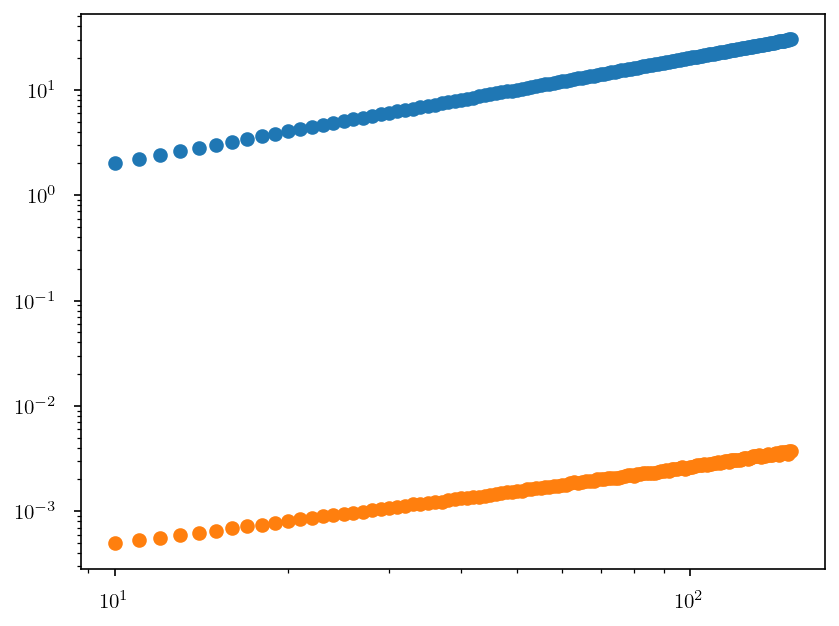

In [9]:
RT_series, VT_series, RT_fit_object, VT_fit_object = find_scale_factors(aggregate_impact_data, alpha=alpha, beta=beta, imbalance_column="volume_imbalance")
# Plot scale factors RN and QN
plt.scatter(RT_series['x_values'], RT_series['y_values'])
plt.scatter(VT_series['x_values'], VT_series['y_values'])
plt.loglog()

In [10]:
RT_fit_object.powerlaw.fit_results()


For powerlaw fitted using MLE:

Pre-fitting parameters;
xmin_index: 10
xmin: 20.0

Fitting parameters;
param_names = ['C', 'alpha']
C = 0.20127674445210844
alpha = 0.9996491046635343

Goodness of fit to data;
D = 0.007633587786259542
bic = -971.7496872487458
mape = 0.04750713445340264
Adjusted R-squared = 0.9999904743146673




In [11]:
VT_fit_object.powerlaw.fit_results()


For powerlaw fitted using MLE:

Pre-fitting parameters;
xmin_index: 10
xmin: 20.0

Fitting parameters;
param_names = ['C', 'alpha']
C = 7.282157162954013e-05
alpha = 0.7814520884706939

Goodness of fit to data;
D = 0.030534351145038167
bic = -2643.1808007064524
mape = 1.453627404492229
Adjusted R-squared = 0.9976947100515355




### Determine rescaling exponents
In order to determine the rescaling exponents $\chi$ and $\varkappa$, the shape of the scaling form is fitted for each $T$ keeping the same/constant values of $\alpha$ $\beta$,</b> which are well approximated by the power law.

In [12]:
chi = RT_fit_object.powerlaw.params.alpha
kappa = VT_fit_object.powerlaw.params.alpha
print(chi)
print(kappa)

0.9996491046635343
0.7814520884706939


### Plot scaling function before collapse
We plot the scaling for different binning_frequencies, where aggregate impact after a trade "appears" to grow linear in volume imbalance with increasing $T$.

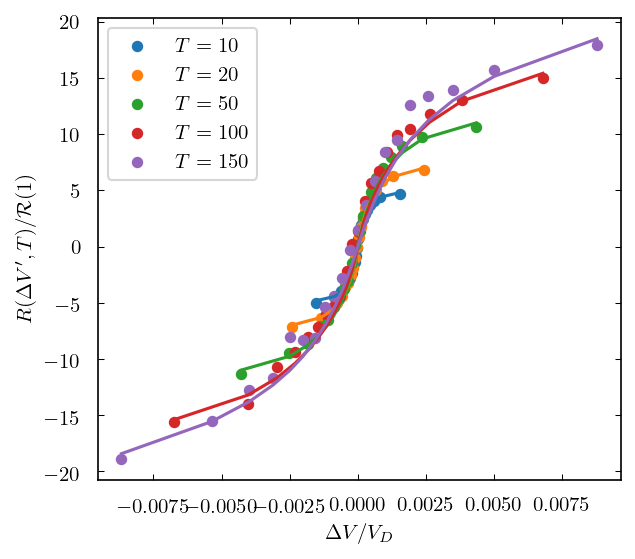

In [13]:
plot_scaling_form(aggregate_impact_data, observation_windows=OBSERVATION_WINDOWS, imbalance_column=imbalance_column)

## Do FSS by method of Least-squares
We can now substitute the found emeprical scaling behaviour for $R_T$ and $V_T$ and use the scaling law to perform the fss, using the optimized critical paramters to rescale the scaling function onto a single master curve by initially fitting the scaling law to all $T$.

In [14]:
# Prepare the data for fitting
T_values = aggregate_impact_data['T'].values
imbalance_values = aggregate_impact_data[imbalance_column].values
R_values = aggregate_impact_data['R'].values

# Fit data for all Ts
original_params = fit_scaling_law(T_values, imbalance_values, R_values, reflect_y=False)

In [15]:
# Retrieve initial optimized parameters
chi, kappa, alpha, beta, CONST = original_params
print(f'chi: {chi}')
print(f'kappa: {kappa}')
print(f'alpha: {alpha}')
print(f'beta: {beta}')
print(f'CONST: {CONST}')

chi: 0.5125780453844683
kappa: 0.818599505839737
alpha: 0.4480693428090853
beta: 39.74031629902456
CONST: 52518.28410065259


In [16]:
# Transform original shape parameters 𝛼 and 𝛽 using found rescaling exponents chi 𝛘 and kapp ϰ
rescaled_params, rescaled_data = transform(aggregate_impact_data, rescaling_params=original_params)

# Retrieve rescaled parameters
chi, kappa, alpha, beta, CONST = rescaled_params
print(f'chi: {chi}')
print(f'kappa: {kappa}')
print(f'alpha: {alpha}')
print(f'beta: {beta}')
print(f'CONST: {CONST}')

chi: 0.005118423371806925
kappa: 1.1429604012977301e-05
alpha: 0.42683671533605416
beta: 33.60862208418035
CONST: 57976.745154368924


### Master curve
Plot the data rescaled by critical exponents chi 𝛘 and kapp ϰ. After appropriate averaging and renomalization, the data collapses onto a single  scaling function (the master curve).

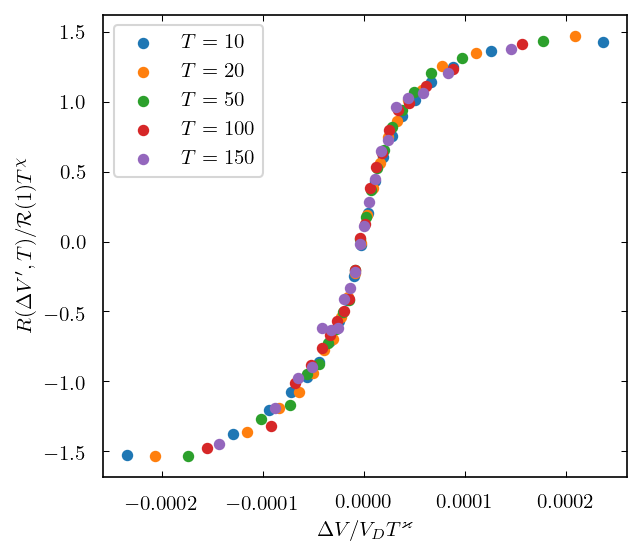

In [17]:
# Plot master curve
plot_scaling_law(aggregate_impact_data=rescaled_data, observation_windows=OBSERVATION_WINDOWS, scaling_params=rescaled_params)